In [10]:
# create a figure with an alpha wave signal and a second figure with a one channel eeg signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from matplotlib.patches import Patch
import mne

In [11]:
cd ~/projects/LAVA/

/home/lisa/projects/LAVA


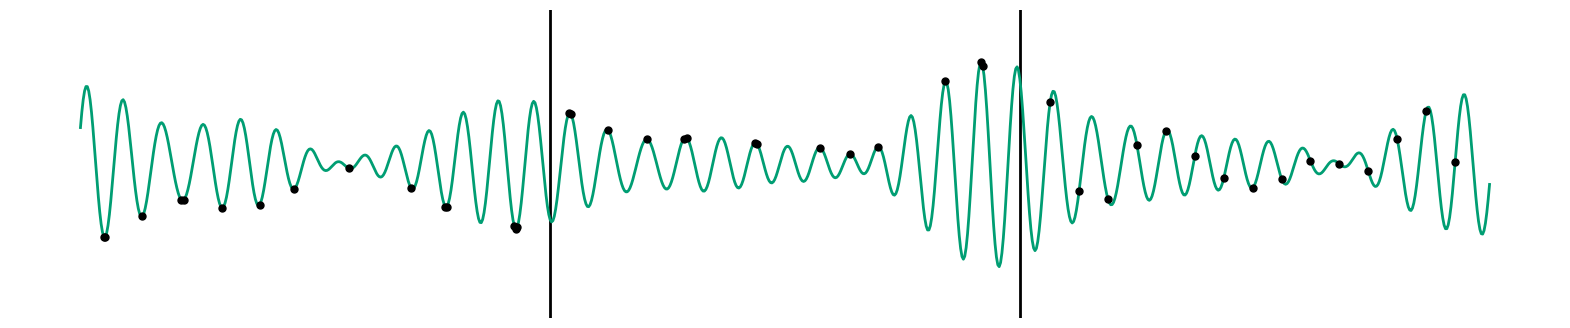

In [72]:
def generate_alpha_wave(sampling_rate=256, duration=4):

    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    # Create natural alpha wave with mixed frequencies and amplitude variations
    # Combine multiple sine waves at different frequencies within alpha band (8-12 Hz)
    alpha_wave = (
        0.5 * np.sin(2 * np.pi * 9.5 * t) +
        0.3 * np.sin(2 * np.pi * 10.2 * t + 0.5) +
        0.25 * np.sin(2 * np.pi * 11 * t + 1.2) +
        0.2 * np.sin(2 * np.pi * 8.7 * t + 0.8)
    )
    # Add slow amplitude modulation for natural waxing/waning effect
    envelope = 1 + 0.3 * np.sin(2 * np.pi * 0.5 * t)
    alpha_wave = alpha_wave * envelope
    # Normalize
    alpha_wave = alpha_wave / np.max(np.abs(alpha_wave))

    return t, alpha_wave

# Generate alpha wave signal
t, alpha_wave = generate_alpha_wave()

t_size = t.shape[0]

# Calculate instantaneous phase using Hilbert transform
from scipy.signal import hilbert
from scipy.signal import find_peaks
analytic_signal = hilbert(alpha_wave)
instantaneous_phase = np.angle(analytic_signal)  # Range: -π to π

# Number of markers per condition
n_markers = 15

# Find actual peaks (local maxima) for 0 phase in first third
peaks_first, _ = find_peaks(alpha_wave[0:int(t_size/3)], distance=20)
if len(peaks_first) > n_markers:
    pi_phase_indices = np.sort(np.random.choice(peaks_first, size=n_markers, replace=False))
else:
    # Fallback to phase-based if not enough peaks
    pi_candidates = np.where(np.abs(np.abs(instantaneous_phase[0:int(t_size/3)]) - np.pi) < 0.3)[0]
    if len(pi_candidates) > n_markers:
        pi_phase_indices = np.sort(np.random.choice(pi_candidates, size=n_markers, replace=False))
    else:
        pi_phase_indices = pi_candidates

# Find actual troughs (local minima) for π phase in second third
troughs_second, _ = find_peaks(-alpha_wave[int(t_size/3)+1:int(2*t_size/3)], distance=20)
if len(troughs_second) > n_markers:
    zero_phase_indices = np.sort(np.random.choice(troughs_second, size=n_markers, replace=False))
else:
    # Fallback to phase-based if not enough troughs
    zero_candidates = np.where(np.abs(instantaneous_phase[int(t_size/3)+1:int(2*t_size/3)]) < 0.3)[0]
    if len(zero_candidates) > n_markers:
        zero_phase_indices = np.sort(np.random.choice(zero_candidates, size=n_markers, replace=False))
    else:
        zero_phase_indices = zero_candidates

# Generate evenly spaced random phase indices for the last third with offset from start
last_third_size = int(t_size) - int(2*t_size/3) - 1
spacing = last_third_size // (n_markers + 1)  # +1 to add padding
random_phase_indices = np.array([spacing + i * spacing for i in range(n_markers)])

# Plot alpha wave signal
plt.figure(figsize=(20, 4))
plt.axvline(x=t[int(t_size/3)], color='black', linestyle='-', linewidth=2)
plt.axvline(x=t[int(2*t_size/3)], color='black', linestyle='-', linewidth=2)
plt.plot(t, alpha_wave, color='#009e73ff', linewidth=2)
# mark the first third with red dots (now at peaks)
plt.scatter(t[pi_phase_indices], alpha_wave[pi_phase_indices], color='black', s=25, label='π Phase', zorder=5)
# mark the second third with blue dots (now at troughs)
plt.scatter(t[int(t_size/3)+1:int(2*t_size/3)][zero_phase_indices[:-1]], alpha_wave[int(t_size/3)+1:int(2*t_size/3)][zero_phase_indices[:-1]], color='black', s=25, label='0 Phase', zorder=5)
# mark random phases in the last third
plt.scatter(t[int(2*t_size/3)+1:int(t_size)][random_phase_indices], alpha_wave[int(2*t_size/3)+1:int(t_size)][random_phase_indices], color='black', s=25, label='Random Phase', zorder=5)
# add vertical lines at each third

plt.ylim(-1.5, 1.5)
plt.axis('off')
plt.savefig('figures/alpha_wave.png', transparent=True, bbox_inches='tight', dpi=400)

plt.show()

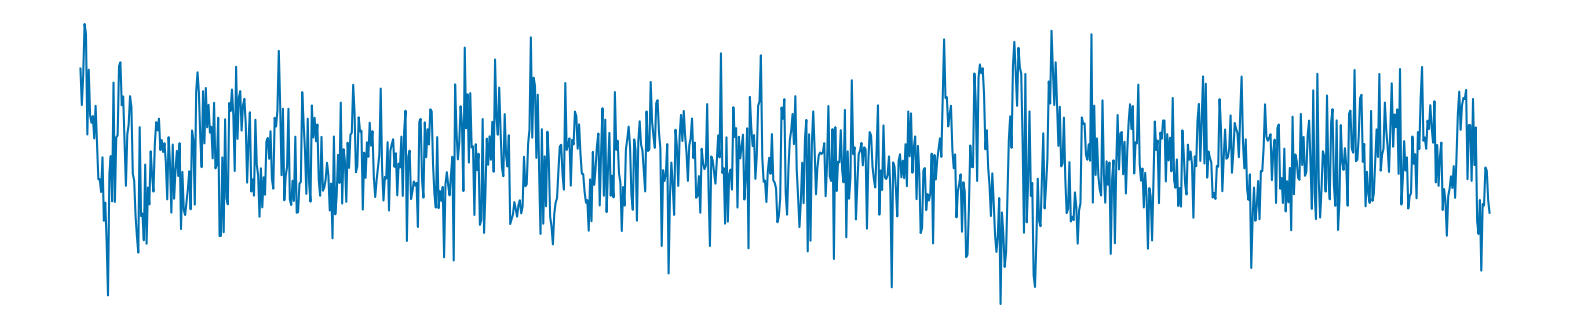

In [13]:
# Generate synthetic EEG signal (1 channel)
np.random.seed(0)
sampling_rate = 256
duration = 4  # seconds
t_eeg = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
# Create a synthetic EEG signal with natural alpha wave and noise
# Generate multi-frequency alpha component
alpha_component = (
    0.5 * np.sin(2 * np.pi * 9.5 * t_eeg) +
    0.3 * np.sin(2 * np.pi * 10.2 * t_eeg + 0.5) +
    0.25 * np.sin(2 * np.pi * 11 * t_eeg + 1.2) +
    0.2 * np.sin(2 * np.pi * 8.7 * t_eeg + 0.8)
)
# Add amplitude modulation
envelope = 1 + 0.3 * np.sin(2 * np.pi * 0.5 * t_eeg)
eeg_signal = alpha_component * envelope * 0.3
eeg_signal += 0.2 * np.random.normal(size=t_eeg.shape)  # Add noise
# Plot EEG signal
plt.figure(figsize=(20, 4))
plt.plot(t_eeg, eeg_signal, color='#0072b2', linewidth=1.5)
plt.axis('off')
plt.savefig('figures/random_eeg_signal.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_2014307/2342612795.py:23: RuntimeWarning: Only 5 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  montage_plot = mne.viz.plot_sensors(info, kind='topomap', show_names=False,
/tmp/ipykernel_2014307/2342612795.py:42: RuntimeWarning: Only 5 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  mne.viz.plot_sensors(info, kind='topomap', show_names=False,


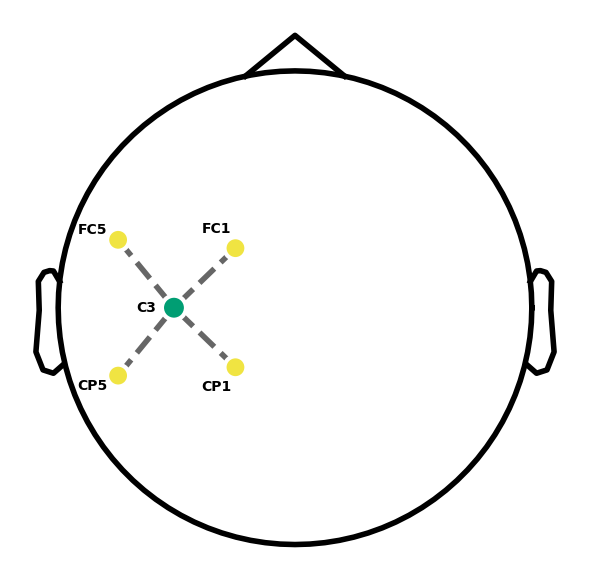

In [81]:

# Create EEG cap schematic with C3 Hjorth filter using MNE
# Load standard 10-05 montage (64 channels, subset of 10-10 system)
montage = mne.channels.make_standard_montage('biosemi64')

# C3 Hjorth filter electrodes
hjorth_center = 'C3'
hjorth_neighbors = ['FC1', 'CP1', 'FC5', 'CP5']

# Create a subset with only the electrodes we need
filter_channels = [hjorth_center] + hjorth_neighbors

# Create info object with only filter channels
info = mne.create_info(ch_names=filter_channels, sfreq=256, ch_types='eeg')
info.set_montage(montage)

# Create figure
fig = plt.figure(figsize=(6, 6))

# Plot the montage with highlighted electrodes
ax = fig.add_subplot(111)

# Get electrode positions first
montage_plot = mne.viz.plot_sensors(info, kind='topomap', show_names=False, 
                                     axes=ax, show=False, sphere='auto',
                                     pointsize=1, linewidth=5)

pos_dict = {}
for collection in ax.collections:
    offsets = collection.get_offsets()
    for i, ch_name in enumerate(filter_channels):
        pos_dict[ch_name] = offsets[i]

# Draw dashed lines connecting neighbors to C3 (in background with lower zorder)
c3_pos = pos_dict[hjorth_center]
for neighbor in hjorth_neighbors:
    neighbor_pos = pos_dict[neighbor]
    ax.plot([neighbor_pos[0], c3_pos[0]], [neighbor_pos[1], c3_pos[1]], 
            'k--', linewidth=2, alpha=0.6, zorder=0)

# Clear and redraw the sensor plot on top (without names)
ax.clear()
mne.viz.plot_sensors(info, kind='topomap', show_names=False, 
                     axes=ax, show=False, sphere='auto',
                     pointsize=150, linewidth=30)

# Redraw lines in background
for neighbor in hjorth_neighbors:
    neighbor_pos = pos_dict[neighbor]
    ax.plot([neighbor_pos[0], c3_pos[0]], [neighbor_pos[1], c3_pos[1]], 
            'k--', linewidth=2, alpha=0.6, zorder=0)

# Now overlay highlights for C3 and neighbors (on top)
for collection in ax.collections:
    offsets = collection.get_offsets()
    
    # Create new colors array
    colors = []
    sizes = []
    
    for ch_name in filter_channels:
        if ch_name == hjorth_center:
            colors.append('#009e73')
            sizes.append(300)
        else:
            colors.append('#f0e442')
            sizes.append(250)
    
    collection.set_facecolors(colors)
    collection.set_sizes(sizes)
    collection.set_edgecolors('white')
    collection.set_linewidths(3)
    collection.set_zorder(10)

# Increase the head outline (sphere) line width
for line in ax.lines:
    line.set_linewidth(4)

# Manually add text labels with moderate offset
for ch_name in filter_channels:
    pos = pos_dict[ch_name]
    # Calculate offset direction (radial from center)
    offset_dist = 0.011  # Moderate distance for labels
    direction = pos / np.linalg.norm(pos)
    label_pos = pos + direction * offset_dist
    
    ax.text(label_pos[0], label_pos[1], ch_name, 
            ha='center', va='center', fontsize=10, 
            fontweight='bold', zorder=20)

plt.axis('off')
plt.tight_layout()
plt.savefig('figures/c3_hjorth_filter.png', transparent=True, bbox_inches='tight', dpi=300, pad_inches=0)
plt.show()


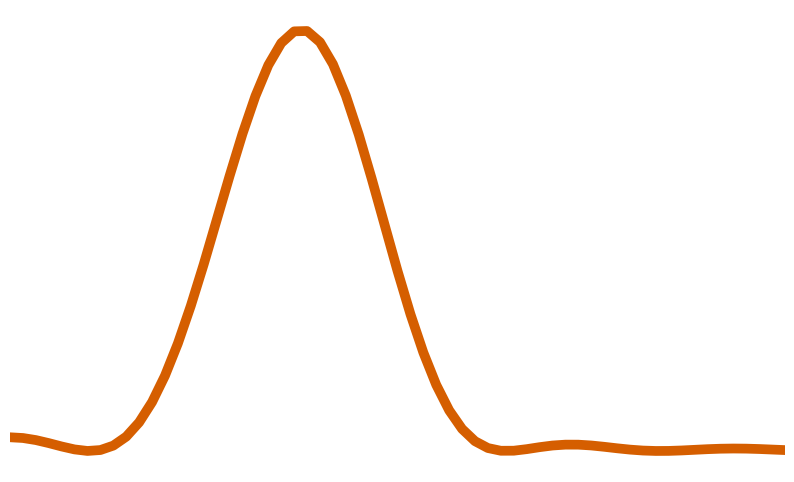

In [40]:
# create a figure of band pass filter power

# load filter weights from mat structure
from scipy.io import loadmat
bp_weights = loadmat('data/filter_coeffs.mat')['coeffs'].flatten()

# Compute frequency response
from scipy.signal import freqz
w, h = freqz(bp_weights)

# get the power response using H * conj(H) like in MATLAB
power = (h * np.conj(h)).real
frequencies = (w / np.pi) * (sampling_rate / 2)

# Plot frequency response
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power, color='#d55e00', linewidth=7)
plt.xlim(0, 15)
plt.axis('off')

plt.savefig('figures/bandpass_filter_response.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()